In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
path = '../dataset/'
all_file = 'icml_face_data.csv'
all_data = pd.read_csv(path+all_file)

In [3]:
#DATA EXPLORATION

In [4]:
emotion_mapping = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
print(all_data.columns)
print(set(all_data[' Usage']))

Index(['emotion', ' Usage', ' pixels'], dtype='object')
{'PrivateTest', 'PublicTest', 'Training'}


In [5]:
train_data = all_data[all_data[' Usage'] == 'Training']
val_data = all_data[all_data[' Usage'] == 'PublicTest']
test_data = all_data[all_data[' Usage'] == 'PrivateTest']
print(' All data ', len(all_data[' Usage']),'\n Training data ', len(train_data[' Usage']),'\n Validation data ', len(val_data[' Usage']), '\n Testing data ', len(test_data[' Usage']))

 All data  35887 
 Training data  28709 
 Validation data  3589 
 Testing data  3589


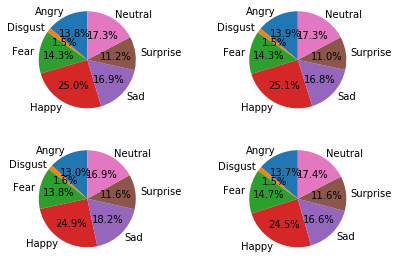

In [6]:
all_frequency = []
train_frequency = []
val_frequency = []
test_frequency = []
for i in emotion_mapping.keys():
    all_frequency.append(all_data['emotion'][all_data['emotion']==i].count())
    train_frequency.append(train_data['emotion'][train_data['emotion']==i].count())
    val_frequency.append(val_data['emotion'][val_data['emotion']==i].count())
    test_frequency.append(test_data['emotion'][test_data['emotion']==i].count())

fig, axs = plt.subplots(2, 2, squeeze = False)
axs[0, 0].pie(all_frequency, explode=None, labels=emotion_mapping.values(),autopct='%1.1f%%',startangle=90, radius = 2)
axs[0, 1].pie(train_frequency, explode=None, labels=emotion_mapping.values(),autopct='%1.1f%%',startangle=90, radius = 2)
axs[1, 0].pie(val_frequency, explode=None, labels=emotion_mapping.values(),autopct='%1.1f%%',startangle=90, radius = 2)
axs[1, 1].pie(test_frequency, explode=None, labels=emotion_mapping.values(),autopct='%1.1f%%',startangle=90, radius = 2)

fig.tight_layout()
plt.show()

In [7]:
for col in train_data.columns:
    print(col, train_data[col].dtypes)

emotion int64
 Usage object
 pixels object


In [8]:
for col in all_data.columns:
    dtype = []
    for i in range(len(all_data)):
        dtype.append(type(all_data[col][i]))
    print(col, set(dtype))

emotion {<class 'numpy.int64'>}
 Usage {<class 'str'>}
 pixels {<class 'str'>}


In [9]:
X_train = np.array([list(map(int, train_data[' pixels'].iloc[i].split()))for i in range(len(train_data[' pixels']))])
X_val = np.array([list(map(int, val_data[' pixels'].iloc[i].split()))for i in range(len(val_data[' pixels']))])
X_test = np.array([list(map(int, test_data[' pixels'].iloc[i].split()))for i in range(len(test_data[' pixels']))])

y_train = train_data['emotion']
y_val = val_data['emotion']
y_test = test_data['emotion']

In [10]:
print('Shape  of X train, val and test ', X_train.shape, X_val.shape, X_test.shape)
print('Shape  of y train, val and test ',y_train.shape, y_val.shape, y_test.shape)

Shape  of X train, val and test  (28709, 2304) (3589, 2304) (3589, 2304)
Shape  of y train, val and test  (28709,) (3589,) (3589,)


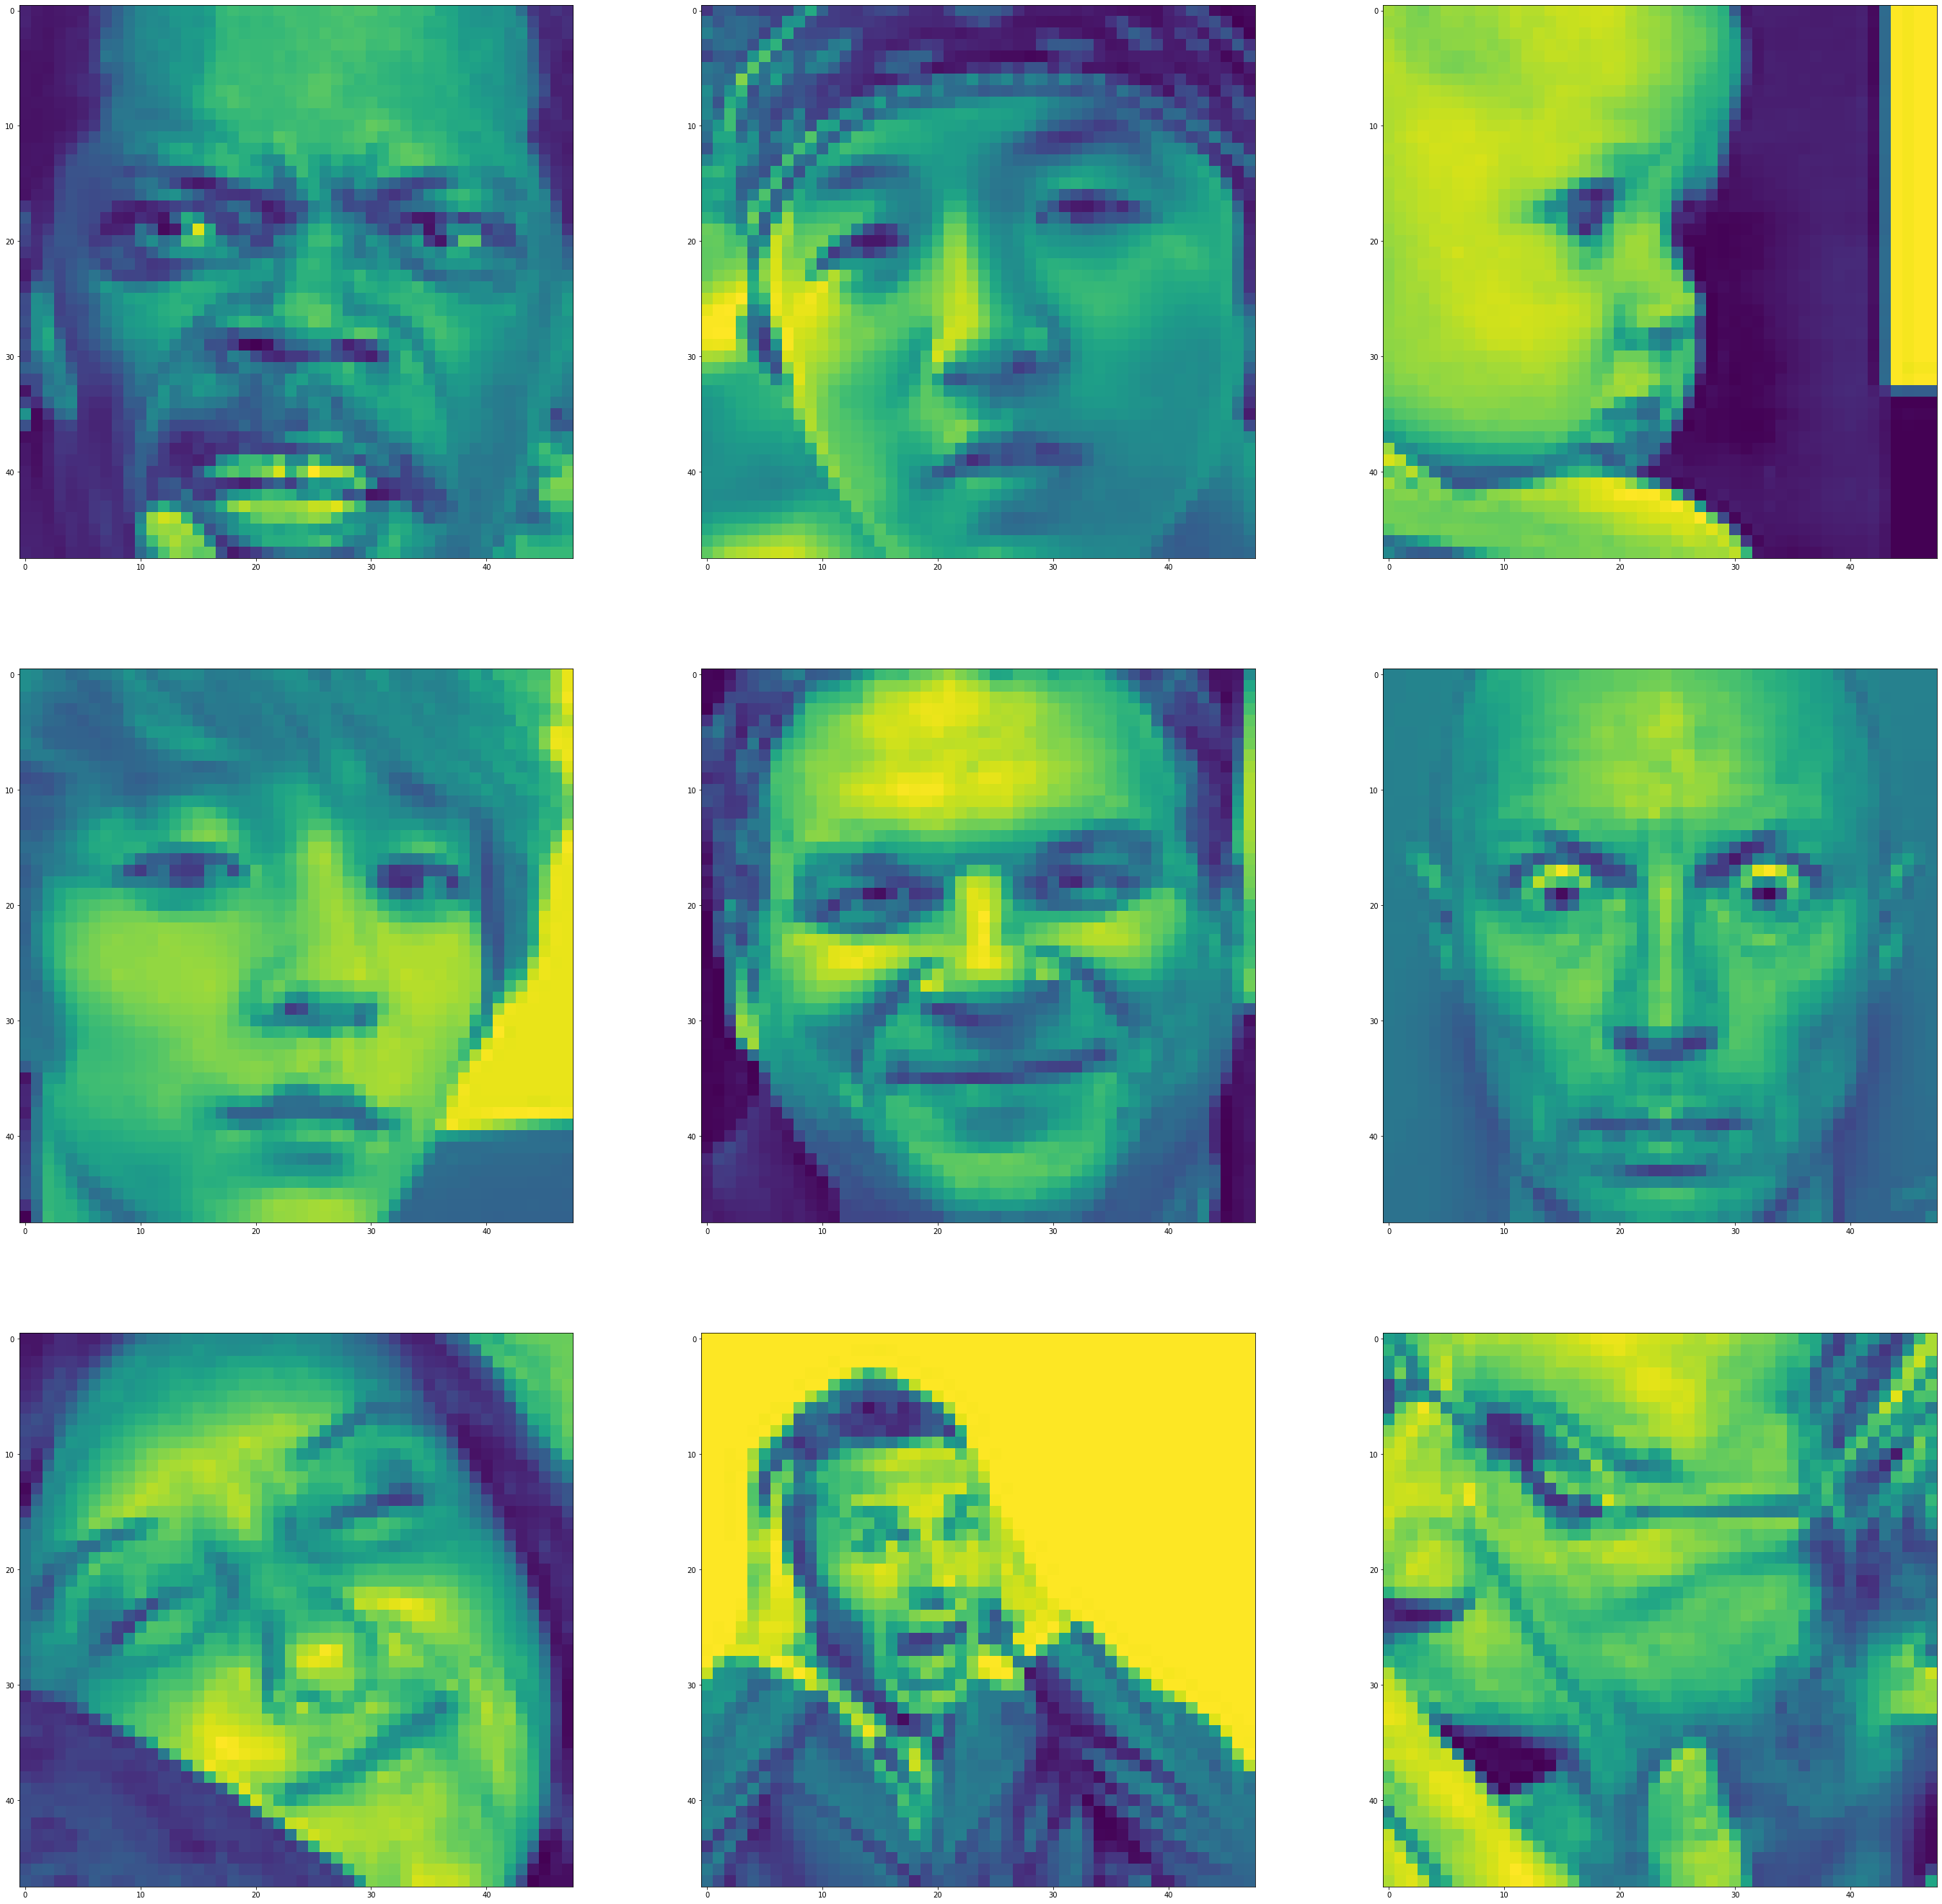

In [11]:
fig, axes = plt.subplots(3,3, figsize=(48,48))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_train.reshape(28709, 48, 48, 1)[i+10,:,:,0])

In [12]:
from sklearn.preprocessing import StandardScaler

train_scale = StandardScaler()
X_sttrain = train_scale.fit_transform(X_train)
X_stval = train_scale.transform(X_val)
X_sttest = train_scale.transform(X_test)

In [13]:
class MajorityClassifier():
    def __init__(self):
        self.counter = 0
    def fit(self, X_train, y_train):
        self.counter = y_train.value_counts(sort = False).idxmax()
    def predict(self, X_test):
        return pd.Series([self.counter]*X_test.shape[0])

In [14]:
class UniformClassifier():
    def __init__(self):
        self.y_values = 0
    def fit(self, X_train, y_train):
        self.y_values = set(y_train)
    def predict(self, X_test):
        return pd.Series(np.random.randint(low = min(self.y_values), high = max(self.y_values), size = X_test.shape[0]))

In [15]:
class SameDistributionClassifier():
    def __init__(self):
        self.y_values = 0
        self.probabilities = 0
    def fit(self, X_train, y_train):
        self.y_values = y_train.value_counts().index.tolist()
        self.probabilities = y_train.value_counts(normalize = True).tolist()
    def predict(self, X_test):
        return pd.Series(np.random.choice(self.y_values, size = X_test.shape[0], p = self.probabilities))

In [16]:
class SimpleConv(keras.Model):

  def __init__(self):
    super(SimpleConv, self).__init__()
    self.norm = keras.layers.BatchNormalization()
    self.conv1 = keras.layers.Conv2D(128, kernel_size = (3, 3), activation = keras.activations.relu)
    self.maxpool = keras.layers.MaxPooling2D()
    self.flatten = keras.layers.Flatten()
    self.dense1 = keras.layers.Dense(6, activation=keras.activations.softmax)

  def call(self, inputs):
    x = self.conv1(inputs)
    x = self.maxpool(x)
    x = self.norm(x)
    x = self.flatten(x)
    x = self.dense1(x)
    return x

In [17]:
X_deeptrain = X_train.reshape(28709, 48, 48, 1).astype('float16')
X_deepval = X_val.reshape(3589, 48, 48, 1)
X_deeptest = X_test.reshape(3589, 48, 48, 1)                   

In [18]:
train_scale = StandardScaler()
X_sttrain = train_scale.fit_transform(X_train)
X_stval = train_scale.transform(X_val)
X_sttest = train_scale.transform(X_test)

In [19]:
majority = MajorityClassifier()
uniform = UniformClassifier()
bernoulli = SameDistributionClassifier()
logistic = LogisticRegression()

majority.fit(X_train, y_train)
uniform.fit(X_train, y_train)
bernoulli.fit(X_train, y_train)
logistic.fit(X_sttrain, y_train)

C:\Users\Hussein\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
import datetime
%load_ext tensorboard
!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [21]:
simple_conv = SimpleConv()
simple_conv.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=["accuracy"])

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

simple_conv.fit(x = X_deeptrain, y = np.array(y_train), batch_size=32, epochs=10, validation_data=(X_deepval, np.array(y_val)), callbacks=[tensorboard_callback])

%tensorboard --logdir logs/fit

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 150s 5ms/sample - loss: 2280.4230 - accuracy: 0.1251 - val_loss: 5827.9492 - val_accuracy: 0.0000e+00
Epoch 2/10
28709/28709 [==============================] - 157s 5ms/sample - loss: 6323.9330 - accuracy: 0.1243 - val_loss: 10238.3416 - val_accuracy: 0.0000e+00
Epoch 3/10
28709/28709 [==============================] - 160s 6ms/sample - loss: 9026.4314 - accuracy: 0.1260 - val_loss: 15078.5810 - val_accuracy: 0.0042
Epoch 4/10
28709/28709 [==============================] - 162s 6ms/sample - loss: 12055.2873 - accuracy: 0.1298 - val_loss: 10832.1864 - val_accuracy: 0.0153
Epoch 5/10
28709/28709 [==============================] - 167s 6ms/sample - loss: 14446.9614 - accuracy: 0.1308 - val_loss: 18108.5397 - val_accuracy: 0.0446
Epoch 6/10
28709/28709 [==============================] - 170s 6ms/sample - loss: 15742.9719 - accuracy: 0.1340 - val_loss: 30707.1884 - val_accuracy: 8.3589

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 1728.

In [22]:
conv = keras.Sequential()
conv.add(keras.layers.Conv2D(128, kernel_size = (3, 3), activation = keras.activations.relu, kernel_initializer='GlorotNormal'))
conv.add(keras.layers.MaxPooling2D())
conv.add(keras.layers.BatchNormalization())
conv.add(keras.layers.Flatten())
conv.add(keras.layers.Dense(6, activation=keras.activations.softmax, kernel_initializer='random_normal'))

In [23]:
conv.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=["accuracy"])

log_dir_1 = "logs_1\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir_1)

conv.fit(x = X_deeptrain, y = np.array(y_train), batch_size=32, epochs=10, validation_data=(X_deepval, np.array(y_val)), callbacks=[tensorboard_callback])

%tensorboard --logdir logs_1/fit

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 153s 5ms/sample - loss: 2093.6095 - accuracy: 0.1562 - val_loss: 10935.0522 - val_accuracy: 0.0000e+00
Epoch 2/10
28709/28709 [==============================] - 148s 5ms/sample - loss: 5387.7343 - accuracy: 0.1581 - val_loss: 8521.0204 - val_accuracy: 0.6985
Epoch 3/10
28709/28709 [==============================] - 149s 5ms/sample - loss: 7790.0025 - accuracy: 0.1608 - val_loss: 9419.4320 - val_accuracy: 2.7863e-04
Epoch 4/10
28709/28709 [==============================] - 150s 5ms/sample - loss: 9616.7105 - accuracy: 0.1618 - val_loss: 13475.7897 - val_accuracy: 0.0156
Epoch 5/10
28709/28709 [==============================] - 164s 6ms/sample - loss: 11744.1026 - accuracy: 0.1636 - val_loss: 16158.5318 - val_accuracy: 0.0103
Epoch 6/10
28709/28709 [==============================] - 176s 6ms/sample - loss: 14831.2697 - accuracy: 0.1668 - val_loss: 14460.7226 - val_accuracy: 0.3268
E

Reusing TensorBoard on port 6006 (pid 7740), started 0:27:57 ago. (Use '!kill 7740' to kill it.)

In [25]:
#Evaluation of the metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

y_maj = majority.predict(X_val)
y_uni = uniform.predict(X_val)
y_ber = bernoulli.predict(X_val)
y_lr = logistic.predict(X_stval)
y_sconv = simple_conv.predict(X_deepval.astype('float16')).argmax(axis = 1)
y_conv = conv.predict(X_deepval.astype('float16')).argmax(axis = 1)

val_output = []

val_output.append(['Majority', accuracy_score(y_val, y_maj), f1_score(y_val, y_maj, average='micro'), f1_score(y_val, y_maj, average='macro')])
val_output.append(['Uniform', accuracy_score(y_val, y_uni), f1_score(y_val, y_uni, average='micro'), f1_score(y_val, y_uni, average='macro')])
val_output.append(['Bernoulli', accuracy_score(y_val, y_ber), f1_score(y_val, y_ber, average='micro'), f1_score(y_val, y_ber, average='macro')])
val_output.append(['Logistic Regression', accuracy_score(y_val, y_lr), f1_score(y_val, y_lr, average='micro'), f1_score(y_val, y_lr, average='macro')])
val_output.append(['Simple Conv', accuracy_score(y_val, y_sconv), f1_score(y_val, y_sconv, average='micro'), f1_score(y_val, y_sconv, average='macro')])
val_output.append(['Conv', accuracy_score(y_val, y_conv), f1_score(y_val, y_conv, average='micro'), f1_score(y_val, y_conv, average='macro')])

columns = ['Classifier', 'Accuracy', 'Micro-F1', 'Macro-F1']
val_output = pd.DataFrame(data = val_output, columns = columns)

print(val_output)

            Classifier  Accuracy  Micro-F1  Macro-F1
0             Majority  0.249373  0.249373  0.057028
1              Uniform  0.144887  0.144887  0.124886
2            Bernoulli  0.173307  0.173307  0.142171
3  Logistic Regression  0.365283  0.365283  0.301696
4          Simple Conv  0.103929  0.103929  0.080551
5                 Conv  0.200334  0.200334  0.101139


In [26]:
y_maj = majority.predict(X_train)
y_uni = uniform.predict(X_train)
y_ber = bernoulli.predict(X_train)
y_lr = logistic.predict(X_sttrain)
y_sconv = simple_conv.predict(X_deeptrain.astype('float16')).argmax(axis = 1)
y_conv = conv.predict(X_deeptrain.astype('float16')).argmax(axis = 1)

train_output = []

train_output.append(['Majority', accuracy_score(y_train, y_maj), f1_score(y_train, y_maj, average='micro'), f1_score(y_train, y_maj, average='macro')])
train_output.append(['Uniform', accuracy_score(y_train, y_uni), f1_score(y_train, y_uni, average='micro'), f1_score(y_train, y_uni, average='macro')])
train_output.append(['Bernoulli', accuracy_score(y_train, y_ber), f1_score(y_train, y_ber, average='micro'), f1_score(y_train, y_ber, average='macro')])
train_output.append(['Logistic Regression', accuracy_score(y_train, y_lr), f1_score(y_train, y_lr, average='micro'), f1_score(y_train, y_lr, average='macro')])
train_output.append(['Simple Conv', accuracy_score(y_train, y_sconv), f1_score(y_train, y_sconv, average='micro'), f1_score(y_train, y_sconv, average='macro')])
train_output.append(['Conv', accuracy_score(y_train, y_conv), f1_score(y_train, y_conv, average='micro'), f1_score(y_train, y_conv, average='macro')])

columns = ['Classifier', 'Accuracy', 'Micro-F1', 'Macro-F1']
train_output = pd.DataFrame(data = train_output, columns = columns)

print(train_output)

            Classifier  Accuracy  Micro-F1  Macro-F1
0             Majority  0.251315  0.251315  0.057383
1              Uniform  0.137762  0.137762  0.119275
2            Bernoulli  0.175172  0.175172  0.144040
3  Logistic Regression  0.449023  0.449023  0.394118
4          Simple Conv  0.102372  0.102372  0.077972
5                 Conv  0.211397  0.211397  0.107220
